# This notebook summarizes the evolution code
## It aims to standarize the function definition with standard data output and input

In [73]:
import numpy as np
import random
import math
# from numba import jit
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns
import time
import pickle
import os
import copy
from concurrent.futures import ProcessPoolExecutor
%autosave 10

Autosaving every 10 seconds


In [85]:
# evolution function definition

class agent6:
    def __init__(self,h1,h2,h3,h4,h5,h6,x=None,y=None):

        self.hop = (h1,h2,h3,h4,h5,h6);
        self.pos = (x,y);
        self.b = resource[x,y]; # resource goes as 0, 1, 2, 3, 4, 5
        self.h = self.hop[int(resource[x,y])]; 

    def updatepos(self,x,y):
        self.pos = (x,y);
        self.b = resource[x,y]; # resource goes as 0, 1, 2, 3, 4, 5
        self.h = self.hop[int(resource[x,y])]; 
        
class agent:
    """
    Agent class encapsulates the information about the position and phenotpye of the agent as well as the agent's current birth and relocation rate.
        
        Parameters:
            h1 to h5 (float): relocation rate or hopping rate of the agent at resource level 1 to 5, which comprises the agent's phenotype
            x, y (int): the x and y coordinate of the agent's location in the 2-dimensional environment
        Functions:
            updatepos(x,y): update the agent's location to (x,y)
    """
    def __init__(self,h1,h2,h3,h4,h5,x=None,y=None):

        self.hop = (h1,h2,h3,h4,h5);
        self.pos = (x,y);
        self.birth = [0,1,2,3,4]
        self.b = self.birth[int(resource[x,y])];  # resource goes as 0, 1, 2, 3, 4
        self.h = self.hop[int(resource[x,y])]; 

    def updatepos(self,x,y):
        self.pos = (x,y);
        self.b = self.birth[int(resource[x,y])]; # resource goes as 0, 1, 2, 3, 4
        self.h = self.hop[int(resource[x,y])];         
        
# def get_num(a,n): # tally agent number at different sites
#     cnt = Counter();
#     for word in [a[i].__dict__['pos'] for i in range(len(a))]:
#         cnt[word] += 1
#     num = [[0 for i in range(n)] for j in range(n)]
#     for i in range(n):
#         for j in range(n):
#             num[i][j] = cnt[(i,j)]
#     return num

def get_num(a,n): 
    """
    Efficiently count agent numbers at all the sites
     
        Parameters: 
            a (list or array): list of agent object;
            n (int): size of the square environment
        Return:
            2-d numpy array: entry at i,j represents the number of agent at location (i,j)
    """
    num=np.zeros((n,n),dtype=int)
    for pos in [a[i].__dict__['pos'] for i in range(len(a))]:
        num[pos]+=1
    return num

def get_num1d(a,n): # tally agent number at different sites 1D
    cnt = Counter();
    for word in [a[i].__dict__['pos'] for i in range(len(a))]:
        cnt[word] += 1
    num = [0 for i in range(n)]
    for i in range(n):
        num[i] = cnt[i]
    return num


def get_i(x,arr,l,r):
    """
    Binary search for the index of an element in a sorted list
        
        Parameters:
            x (float): target to be located for
            arr (list or numpy array): a sorted list where the target will be located at
            l (int): left pointer, usually start with 0
            r (int): right pointer, usually start with len(a)
        Return:
            i (int): index that arr[i]<=x<=arr[i+1]
    """
    if x <= arr[0]:
        return 0
    else:
        while l <= r: 
            mid = l + int((r - l)/2); 
            # Check if x is present at mid 
            if arr[mid] < x and arr[mid+1] >= x: 
                return mid+1 
            # If x is greater, ignore left half 
            elif arr[mid+1] < x: 
                l = mid + 1
            # If x is smaller, ignore right half 
            else: 
                r = mid 
        raise Exception("Target not found")

def uniform_resource6(x,y):
    return np.random.choice([0,1,2,3,4,5], size=(x,y))

def uniform_resource(x,y):
    """Return a uniformly generated 2-dimensional numpy array representing the resource level at each site"""
    return np.random.choice([0,1,2,3,4], size=(x,y))
def uniform_resource1d(x):
    return np.random.choice([0,1,2,3,4], size=x)

def exponetial_resource(x,y):
    p = [np.exp(-i*0.5) for i in range(1,6)]
    p = p/np.sum(p)
    return np.random.choice([0,1,2,3,4],size=(x,y),p=p)
def intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500):  
#     xx = [random.randint(0, n-1) for _ in range(m)]
#     yy = [random.randint(0, n-1) for _ in range(m)]
    a=[(x,y) for x in range(n) for y in range(n)]
    xy=[a[i] for i in random.sample(range(len(a)),m) ]
#     list(zip(np.array(xy).T[0],np.array(xy).T[1]))
#     xy=
    if _type == 'uniform':
        h1 = np.random.uniform(0,hop_high,m) 
        h2 = np.random.uniform(0,hop_high,m) 
        h3 = np.random.uniform(0,hop_high,m) 
        h4 = np.random.uniform(0,hop_high,m)
        h5 = np.random.uniform(0,hop_high,m)
#         h6 = np.random.uniform(0,hop_high,m)
    elif _type == 'step':
        h1 = np.array([hop_high]*m)
        h2 = np.array([hop_high]*m)
        h3 = np.array([hop_high]*m)
        h4 = np.array([hop_high]*m)
        h5 = np.array([0]*m)
        
    return [agent(q,w,e,r,t,k,l) for q,w,e,r,t,k,l in zip(h1,h2,h3,h4,h5,np.array(xy).T[0],np.array(xy).T[1])]

def evolve(total_iteration,  initial_condition,trialnumber, n = 128,noisestd = 0.01, datastoretype=100, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note=None):
#     count=[0,0,0,0,0] # steps (total number of birth and hop trials), successful birth steps, failed birth, successful hop, failed hop
#     birth_count_yes=[0,0,0,0,0] # successful birth at resource level, 0, 1, 2, 3, 4
#     birth_count_no=[0,0,0,0,0]# failed birth at resource level, 0, 1, 2, 3, 4
#     hop_count_yes=[0,0,0,0,0] # successful hop at resource level, 0, 1, 2, 3, 4
#     hop_count_no=[0,0,0,0,0]# failed hop at resource level, 0, 1, 2, 3, 4
#     n = 128; # number of sites on 1D
    m = initialagentnumber; # number of initial agents
    _path = './evolve_data'+'/{}'.format(time.strftime("%Y_%m_%d_%H_%M",time.localtime()))+'/trial_{}'.format(trialnumber)
    os.makedirs(_path,exist_ok=True)
    info = {"lattice": "{}*{}".format(n,n), "total_iteartion": total_iteration, "evolve_time": T, "noise":noisestd, "carrying_capacity": K, "initial_angent_number":initialagentnumber, "data_stored_every":datastoretype,"note":note}
    with open(_path+'/simulation_info.txt', "wb") as fp: 
        pickle.dump(info, fp)
    with open(_path+'/resource.txt', "wb") as fp: 
        pickle.dump(resource, fp)
        
    a = copy.deepcopy(initial_condition)
    with open(_path+'/iteration_00', "wb") as fp: 
        pickle.dump(a, fp)
    for iteration in range(total_iteration):
        t = 0
        num = get_num(a,n)
        br = [a[i].b for i in range(len(a))]
        hr = [a[i].h for i in range(len(a))]
        
        while t < T:
           
            brsum = sum(br)
            w = brsum + sum(hr); # total rates
            dt = -math.log(random.uniform(0.0,1.0)) / w
            t = t + dt
            r = w * random.uniform(0.0,1.0)

            if r < brsum:
                 # birth
#                 tot = np.sum(num);
#                 if tot == K * n * n:
#                     break

                i = get_i(r,np.cumsum(br),0,len(a)-1);
#                 hop = [0,0];
                hh = random.randint(1, 4);# randchoice
                if hh == 1:
                    hop = [1,0];
                elif hh == 2:
                    hop = [0,1];
                elif hh == 3:
                    hop = [-1,0];
                else:
                    hop = [0,-1];

                if a[i].pos[0]+hop[0] == n:
                    hop[0] = -(n-1);
                elif a[i].pos[0]+hop[0] == -1:
                    hop[0] = n-1;
                elif a[i].pos[1]+hop[1] == n:
                    hop[1] = -(n-1);
                elif a[i].pos[1]+hop[1] == -1:
                    hop[1] = n-1;

                if num[a[i].pos[0]+hop[0]][a[i].pos[1]+hop[1]] < K:
#                     count[1]+=1
#                     birth_count_yes[int(a[i].b)]+=1
    #             if num[a[i].pos[0]][a[i].pos[1]] < K: # for local birth
    #                 print('birth ');
#                     print(tot)
                    noise1 = np.random.normal(0, noisestd, 1)[0];
                    noise2 = np.random.normal(0, noisestd, 1)[0];
                    noise3 = np.random.normal(0, noisestd, 1)[0];
                    noise4 = np.random.normal(0, noisestd, 1)[0];
                    noise5 = np.random.normal(0, noisestd, 1)[0];
#                     noise6 = np.random.normal(0, noisestd, 1)[0];
                    
                    if a[i].hop[0]+noise1 > hop_high:
                        noise1 = hop_high - a[i].hop[0];
                    elif a[i].hop[0]+noise1 < 0:
                        noise1 = -a[i].hop[0]; 
                        
                    if a[i].hop[1]+noise2 < 0:
                        noise2 = -a[i].hop[1];
                    elif a[i].hop[1]+noise2 >  hop_high:
                        noise2 =  hop_high - a[i].hop[1];
                        
                    if a[i].hop[2]+noise3 < 0:
                        noise3 = -a[i].hop[2];
                    elif a[i].hop[2]+noise3 >  hop_high:
                        noise3 =  hop_high - a[i].hop[2];
                        
                    if a[i].hop[3]+noise4 < 0:
                        noise4 = -a[i].hop[3];
                    elif a[i].hop[3]+noise4 >  hop_high:
                        noise4 =  hop_high - a[i].hop[3];
                        
                    if a[i].hop[4]+noise5 < 0:
                        noise5 = -a[i].hop[4];
                    elif a[i].hop[4]+noise5 >  hop_high:
                        noise5 =  hop_high - a[i].hop[4];
                        
#                     if a[i].hop[5]+noise6 < 0:
#                         noise6 = -a[i].hop[5];
#                     elif a[i].hop[5]+noise6 >  hop_high:
#                         noise6 =  hop_high - a[i].hop[5];
                        
                    a.append(agent(a[i].hop[0]+noise1,a[i].hop[1]+noise2,a[i].hop[2]+noise3,a[i].hop[3]+noise4,a[i].hop[4]+noise5,a[i].pos[0]+hop[0],a[i].pos[1]+hop[1]))                     
                    num[a[i].pos[0]+hop[0]][a[i].pos[1]+hop[1]] +=1
                    br.append(a[-1].b)
                    hr.append(a[-1].h)
    
            else:
                # hopping
                i = get_i(r,brsum+np.cumsum(hr),0,len(a)-1);

                hd = random.randint(1, 4);# randchoice
                if hd == 1:
                    hop = [1,0];
                elif hd == 2:
                    hop = [0,1];
                elif hd == 3:
                    hop = [-1,0];
                else:
                    hop = [0,-1];

                if a[i].pos[0]+hop[0] == n:
                    hop[0] = -(n-1);
                elif a[i].pos[0]+hop[0] == -1:
                    hop[0] = n-1;
                elif a[i].pos[1]+hop[1] == n:
                    hop[1] = -(n-1);
                elif a[i].pos[1]+hop[1] == -1:
                    hop[1] = n-1;

                if num[a[i].pos[0]+hop[0]][a[i].pos[1]+hop[1]] < K:
                    num[a[i].pos[0]+hop[0]][a[i].pos[1]+hop[1]]+=1
                    num[a[i].pos[0]][a[i].pos[1]]-=1
                    a[i].updatepos(a[i].pos[0]+hop[0],a[i].pos[1]+hop[1])
                    br[i]=a[i].b
                    hr[i]=a[i].h
#                 else:
#                     count[4] +=1
#                     hop_count_no[int(a[i].b)]+=1
        # remove high resource agents
#         poss = [a[j].pos for j in range(len(a))] # position tuple list
#         indextopop = [j for j in range(len(a)) if (poss[j][0]+poss[j][1]) % 2 == 1] # select the index to delete
#         aa = [a[i] for i in indextopop] # create new object list
#         a = aa
        if len(a) > m:
#             print(len(a))
            reset = random.sample(range(len(a)), m) # randomly generate m agents to keep for the next iteration
            a = [a[i] for i in reset]
            
        if iteration%datastoretype == 0:
            with open(_path+'/iteration_{}'.format(iteration), "wb") as fp: 
                pickle.dump(a, fp)

    return a;


In [13]:
# data visualization function

def plotsingleviolin(data): # make violion plot for a single trail data
#     a =results2d128128cc1copies20with2000catast_nonoise[0].result()
    hop = np.zeros((5,500))
    for j in range(5):
        hop[j] = [data[i].__dict__['hop'][j] for i in range(len(data))]
    df = pd.DataFrame(hop.T,columns=(r'$S_1$',r'$S_2$',r'$S_3$',r'$S_4$',r'$S_5$'))
    fig, ax1 = plt.subplots()

    fsize = 12
    color = 'k'
    ax1.set_xlabel("Resource Level",fontsize = fsize)
    ax1.set_ylabel("Hopping Rate Distribution",color=color,fontsize = fsize)
    ax1.plot(df.median(),color=color,label='Simulated')

    sns.violinplot(data=df,scale='area',inner='box',cut=0, figsize=(20,20))
    #     plt.ylim(-0.5,10.5)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_aspect(1/ax1.get_data_ratio())
    # ax1.set_ylim(-1.5,11.5)
    color = 'b'
    ax2 = fig.add_axes(ax1.get_position())
    ax2.set_facecolor("None")
    ax2.set_aspect('equal')
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    # ax2.plot([5,0],[0,2], color="red")
    #     ax2.plot(range(5),[10-10*(1-x)**4 for x in [4/5-b/5 for b in range(5)]],'--', color=color,label='Predicted')
    ax2.set_aspect(1/ax2.get_data_ratio())
    ax2.set_ylabel('Predicted Hopping Rate', color=color,fontsize = fsize)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.tick_params(bottom=0, top=0, left=0, right=1, 
                    labelbottom=0, labeltop=0, labelleft=0, labelright=1,labelcolor=color)
    
def plotcopiesvariability(copy,title,alldata=None,foodata=None): #multi trails median plot
    if foodata!=None:    
        alldata = [foodata[i].result() for i in range(copy)];
    boxdata=[np.median(np.array([alldata[j][i].hop for i in range(500)]),axis=0) for j in range(copy)]
    for j in range(copy):
        plt.plot(range(1,6),boxdata[j])
    plt.xticks(np.arange(1,6), ('$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$'),fontsize= 15)
    plt.ylabel('Relocation Rate',fontsize= 15)
    plt.xlabel('Phenotype component',fontsize= 15)
    plt.yticks(fontsize=15)
    plt.plot(range(1,6),[10-10*(x)**4 for x in [b/5 for b in range(1,6)]],'--',label='Predicted')
    plt.legend(loc='lower left', bbox_to_anchor=(0.08, 0.08),frameon=False,fontsize=15)
    fig = plt.gcf()
    fig.set_size_inches(6.5, 6.5)
    plt.title(title,fontsize= 15)
#     plt.savefig('{} catastrophes.pdf'.format(catastrophes))
    
def plotcopiesbox(copy,title,alldata=None,foodata=None): #multi trails box plot
    if foodata!=None:    
        alldata = [foodata[i].result() for i in range(copy)];
    boxdata=[np.median(np.array([alldata[j][i].hop for i in range(500)]),axis=0) for j in range(copy)]
    plt.boxplot([np.array(boxdata).T[i,:] for i in range(5)])
    plt.plot(range(1,6),[10-10*(x)**4 for x in [b/5 for b in range(1,6)]],'--',label='Predicted')
    plt.legend(loc='lower left', bbox_to_anchor=(0.08, 0.08),frameon=False,fontsize=15)
    plt.xticks(np.arange(1,6), ('$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$'),fontsize= 15)
    plt.yticks(fontsize=15)
    plt.title(title,fontsize= 15)
    plt.ylabel('Relocation Rate',fontsize= 15)
    plt.xlabel('Phenotype component',fontsize= 15)
    fig = plt.gcf()
    fig.set_size_inches(6.5, 6.5)
#     plt.savefig('{} catastrophes_boxplot.pdf'.format(catastrophes))

In [87]:
# b=intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500)
evolve(total_iteration=1,initial_condition=b,trialnumber=i)

In [63]:

# with open('./evolve_data/2020_08_17_13_41/trail_19/resource.txt', "rb") as fp: 
#     resource=pickle.load(fp)
# resource=uniform_resource(128,128)
# with open("./evolve_data/2020_05_02_16_02_47/trail_{}/resource.txt".format(1), "rb") as fp:   # Unpickling
#             resource= pickle.load(fp)
with ProcessPoolExecutor() as executor:
    test = [executor.submit(evolve,total_iteration=20001,initial_condition=intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500),trialnumber=i,n = 128, noisestd = 0.05, datastoretype=200, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note='standard parameters (optimized algorithm) 3rd run: uniform resource initial 500 agents, 5 resource levels, [0,1,2,3,4], 128*128 sites, T=0.3 k=1') for i in range(20)]
# test= evolve(total_iteration=100,initial_condition=intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500),trailnumber=0, noisestd = 0.05, datastoretype=1, 
#            initialagentnumber=500, T=0.002,K = 1, hop_high = 10,note='speed test')
# evolve(10,intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500),0)

In [62]:
with open('./evolve_data/2021_04_08_14_50/trail_19/resource.txt', "rb") as fp: 
    resource=pickle.load(fp)
with ProcessPoolExecutor() as executor:
    test = [executor.submit(evolve,total_iteration=20001,initial_condition=intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500),trialnumber=i,n = 128, noisestd = 0.05, datastoretype=50, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note='standard parameters (optimized algorithm) 2nd run with more data stored (every 50 iter): uniform resource initial 500 agents, 5 resource levels, [0,1,2,3,4], 128*128 sites, T=0.3 k=1') for i in range(20)]


In [13]:
# multiprocessing

from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor() as executor:
    new = [executor.submit(evolve,total_iteration=20001,initial_condition=intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500),trailnumber=i, noisestd = 0.05, datastoretype=50, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note='6 resource levels, 0-5, uniform initial condition, noise 0.05, to test how does a new added phenotype component change the optimal phenotype combinations') for i in range(20)]


In [17]:
# continue from above
alldata = [test[i].result() for i in range(20)]
from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor() as executor:
    foo3= [executor.submit(evolve,total_iteration=20000,initial_condition=alldata[i],trailnumber=i, noisestd = 0.05, datastoretype=50, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note='continue after 40000 iterations with noise 0.05 and uniform initial conditions, data stored on 2020_04_18_19_13_53 and 2020_04_22_20_40_08') for i in range(20)]


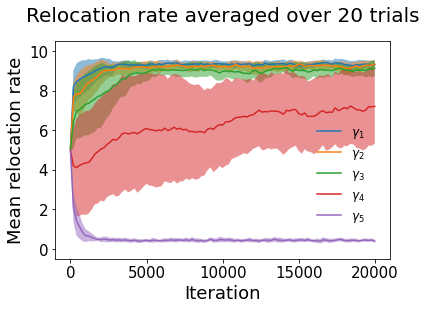

In [104]:
iteration =20001
var=[[] for _ in range(len(range(0,iteration,200)))]
ave=[[] for _ in range(len(range(0,iteration,200)))]
for i in range(0,iteration,200):
    data=[[] for _ in range(20)]

    boxdata=[]
    for j in range(20):
#         with open("./evolve_data/2020_06_17_01_25/trail_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
#             data[j] = pickle.load(fp)
        try:
            with open("./evolve_data/2021_04_08_14_50/trail_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trail_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
#     boxdata=[np.median(np.array([data[j][i].hop for i in range(500)]),axis=0) for j in range(20)]
    var[int(i/200)]=np.var(np.array(boxdata).T,1)
    ave[int(i/200)]=np.average(np.array(boxdata).T,1)
# for i in range(5):    
#     plt.plot(np.sqrt(np.array(var))[:,i],label="component {}".format(i+1))
# plt.ylabel('STD of the medians of 20 copies')   
# plt.xlabel('Iterations/50')
# # plt.title('noise 0.05 uniform local birth')
# plt.legend()
# plt.show()
for i in range(5):    
    plt.plot(np.linspace(0,20000,101),np.array(ave)[:,i],'-',label="$\gamma_{}$".format(i+1))
    plt.fill_between(np.linspace(0,20000,101),np.array(ave)[:,i]-np.sqrt(np.array(var))[:,i], np.array(ave)[:,i]+np.sqrt(np.array(var))[:,i], alpha=0.5)
plt.ylabel('Mean relocation rate',fontsize = 18)   
plt.xlabel('Iteration',fontsize =18 )
# plt.xticks(fontsize=12)
# plt.title('Relocation rate averaged over 20 trials',fontsize=18)
plt.text(10000, 11.5, 'Relocation rate averaged over 20 trials',
         horizontalalignment='center',
         fontsize=20)
# plt.title('0 1 2 3 4 k =1 32*32 site')
plt.legend(bbox_to_anchor=(0.75, 0.11),frameon=False,fontsize=12)
plt.ylim(-0.5,10.5)
plt.gca().set_xticks([0,5000,10000,15000,20000])
plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)
# plt.legend()
# plt.show()
# plt.savefig('./Paper_1_Figures/evo_iteration_density0_ave.pdf')

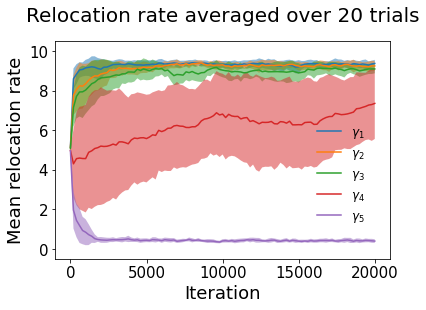

In [111]:
iteration =20001
var=[[] for _ in range(len(range(0,iteration,200)))]
ave=[[] for _ in range(len(range(0,iteration,200)))]
for i in range(0,iteration,200):
    data=[[] for _ in range(20)]

    boxdata=[]
    for j in range(20):
#         with open("./evolve_data/2020_06_17_01_25/trail_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
#             data[j] = pickle.load(fp)
        try:
            with open("./evolve_data/2021_04_09_12_00/trial_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trail_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
#     boxdata=[np.median(np.array([data[j][i].hop for i in range(500)]),axis=0) for j in range(20)]
    var[int(i/200)]=np.var(np.array(boxdata).T,1)
    ave[int(i/200)]=np.average(np.array(boxdata).T,1)
# for i in range(5):    
#     plt.plot(np.sqrt(np.array(var))[:,i],label="component {}".format(i+1))
# plt.ylabel('STD of the medians of 20 copies')   
# plt.xlabel('Iterations/50')
# # plt.title('noise 0.05 uniform local birth')
# plt.legend()
# plt.show()
for i in range(5):    
    plt.plot(np.linspace(0,20000,101),np.array(ave)[:,i],'-',label="$\gamma_{}$".format(i+1))
    plt.fill_between(np.linspace(0,20000,101),np.array(ave)[:,i]-np.sqrt(np.array(var))[:,i], np.array(ave)[:,i]+np.sqrt(np.array(var))[:,i], alpha=0.5)
plt.ylabel('Mean relocation rate',fontsize = 18)   
plt.xlabel('Iteration',fontsize =18 )
# plt.xticks(fontsize=12)
# plt.title('Relocation rate averaged over 20 trials',fontsize=18)
plt.text(10000, 11.5, 'Relocation rate averaged over 20 trials',
         horizontalalignment='center',
         fontsize=20)
# plt.title('0 1 2 3 4 k =1 32*32 site')
plt.legend(bbox_to_anchor=(0.75, 0.11),frameon=False,fontsize=12)
plt.ylim(-0.5,10.5)
plt.gca().set_xticks([0,5000,10000,15000,20000])
plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)
# plt.legend()
# plt.show()
# plt.savefig('./Paper_1_Figures/evo_iteration_density0_ave.pdf')

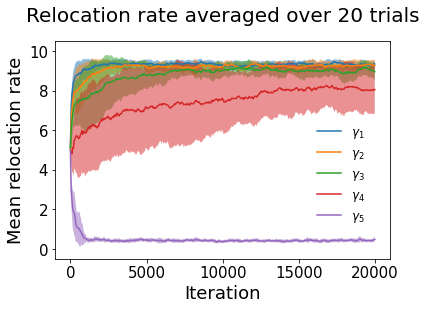

In [109]:
iteration =20001
var=[[] for _ in range(len(range(0,iteration,50)))]
ave=[[] for _ in range(len(range(0,iteration,50)))]
for i in range(0,iteration,50):
    data=[[] for _ in range(20)]

    boxdata=[]
    for j in range(20):
#         with open("./evolve_data/2020_06_17_01_25/trail_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
#             data[j] = pickle.load(fp)
        try:
            with open("./evolve_data/2021_04_08_21_48/trial_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trail_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
#     boxdata=[np.median(np.array([data[j][i].hop for i in range(500)]),axis=0) for j in range(20)]
    var[int(i/50)]=np.var(np.array(boxdata).T,1)
    ave[int(i/50)]=np.average(np.array(boxdata).T,1)

for i in range(5):    
    plt.plot(np.linspace(0,20000,401),np.array(ave)[:,i],'-',label="$\gamma_{}$".format(i+1))
    plt.fill_between(np.linspace(0,20000,401),np.array(ave)[:,i]-np.sqrt(np.array(var))[:,i], np.array(ave)[:,i]+np.sqrt(np.array(var))[:,i], alpha=0.5)
plt.ylabel('Mean relocation rate',fontsize = 18)   
plt.xlabel('Iteration',fontsize =18 )
# plt.xticks(fontsize=12)
# plt.title('Relocation rate averaged over 20 trials',fontsize=18)
plt.text(10000, 11.5, 'Relocation rate averaged over 20 trials',
         horizontalalignment='center',
         fontsize=20)
# plt.title('0 1 2 3 4 k =1 32*32 site')
plt.legend(bbox_to_anchor=(0.75, 0.11),frameon=False,fontsize=12)
plt.ylim(-0.5,10.5)
plt.gca().set_xticks([0,5000,10000,15000,20000])
plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)
# plt.legend()
# plt.show()
# plt.savefig('./Paper_1_Figures/evo_iteration_density0_ave.pdf')

In [103]:
ave[0][1]

7.488221335168309

In [156]:
with open("./evolve_data/2020_04_12_13_35_31/trail_{}/simulation_info.txt".format(0), "rb") as fp:   # Unpickling
    info = pickle.load(fp)
info

{'lattice': '128*128',
 'total_iteartion': 20,
 'evolve_time': 0.3,
 'noise': 0.01,
 'carrying_capacity': 1,
 'initial_angent_number': 500,
 'data_stored_every': 2,
 'note': 'to test what uniform initial condition converges to with noise 0.01 and how fast does it converge'}

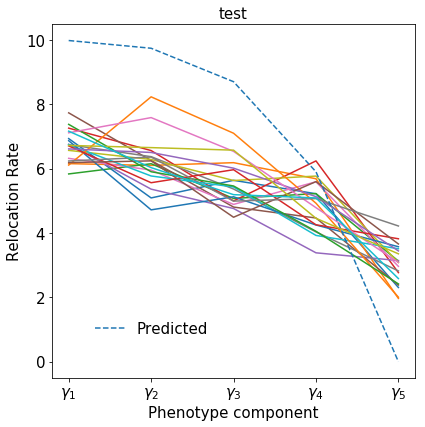

In [157]:
plotcopiesvariability(alldata=None,foodata=foo,copy=20,title="test")

In [8]:
alldata = [foo[i].result() for i in range(20)]

In [11]:
len(alldata[1])

500